In [1]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
     

In [2]:
df = pd.read_csv("Data.csv", encoding='utf-8')
df

,tweet
0,If I smelled the scent of hand sanitizers toda...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,@brookbanktv The one gift #COVID19 has give me...
4,25 July : Media Bulletin on Novel #CoronaVirus...
...,...
37608,Want the latest analyst ratings on $EXEL $UHS ...
37609,RT @OptionAlert: $ETFC call buyer rolls 200% g...
37610,Schlumberger LTD $SLB Holding Maintained by Ke...
37611,RT @marketminute: Put this out a few weeks ago...


In [3]:
# df['tweet']=df['tweet'].values.astype(str)

In [4]:
def give_emoji_free_text(text):
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    text = re.sub(r'http\S+', '', text)
    return text

call_emoji_free = lambda x: give_emoji_free_text(x)

df['emoji_free_tweets'] = df['tweet'].apply(call_emoji_free)

df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)
     

In [5]:
nlp = spacy.load("en_core_web_lg")

In [6]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [7]:
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m','im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [8]:
df

,tweet,emoji_free_tweets,url_free_tweets,tokens
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...,"[smelled, scent, hand, sanitizers, today, past..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,"[hey, @yankees, @yankeespr, @mlb, wouldn't, se..."
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realDonaldTrump Trump nev...,"[@diane3443, @wdunlap, @realdonaldtrump, trump..."
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv The one gift #COVID19 has give me...,"[@brookbanktv, gift, #covid19, appreciation, s..."
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...,"[25, july, :, media, bulletin, novel, #coronav..."
...,...,...,...,...
37608,Want the latest analyst ratings on $EXEL $UHS ...,Want the latest analyst ratings on $EXEL $UHS ...,Want the latest analyst ratings on $EXEL $UHS ...,"[latest, analyst, ratings, $exel, $uhs, $cna, ..."
37609,RT @OptionAlert: $ETFC call buyer rolls 200% g...,RT @OptionAlert: $ETFC call buyer rolls 200% g...,RT @OptionAlert: $ETFC call buyer rolls 200% g...,"[rt, @optionalert:, $etfc, buyer, rolls, 200%,..."
37610,Schlumberger LTD $SLB Holding Maintained by Ke...,Schlumberger LTD $SLB Holding Maintained by Ke...,Schlumberger LTD $SLB Holding Maintained by Ke...,"[schlumberger, ltd, $slb, holding, maintained,..."
37611,RT @marketminute: Put this out a few weeks ago...,RT @marketminute: Put this out a few weeks ago...,RT @marketminute: Put this out a few weeks ago...,"[rt, @marketminute:, weeks, ago., clears, 140,..."


In [9]:
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
     

In [10]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
     

<>:12: DeprecationWarning: invalid escape sequence '\w'
<>:12: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_14926/3831837225.py:12: DeprecationWarning: invalid escape sequence '\w'
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers


In [11]:
df

,tweet,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...,If I smelled the scent of hand sanitizers toda...,"[smelled, scent, hand, sanitizers, today, past...","smelled scent hand sanitizers today past, thin...","[smell, scent, hand, sanitizer, today, past, t...",smell scent hand sanitizer today past think in...,"[smell, scent, hand, sanitizer, today, past, t..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,"[hey, @yankees, @yankeespr, @mlb, wouldn't, se...",hey @yankees @yankeespr @mlb wouldn't sense pl...,"[hey, @yankees, @yankeespr, @mlb, sense, playe...",hey @yankees @yankeespr @mlb sense player pay ...,"[hey, yankees, yankeespr, mlb, sense, player, ..."
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realDonaldTrump Trump nev...,@diane3443 @wdunlap @realDonaldTrump Trump nev...,"[@diane3443, @wdunlap, @realdonaldtrump, trump...",@diane3443 @wdunlap @realdonaldtrump trump cla...,"[@diane3443, @wdunlap, @realdonaldtrump, trump...",@diane3443 @wdunlap @realdonaldtrump trump cla...,"[diane3443, wdunlap, realdonaldtrump, trump, c..."
3,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv The one gift #COVID19 has give me...,@brookbanktv The one gift #COVID19 has give me...,"[@brookbanktv, gift, #covid19, appreciation, s...",@brookbanktv gift #covid19 appreciation simple...,"[@brookbanktv, gift, covid19, appreciation, si...",@brookbanktv gift covid19 appreciation simple ...,"[brookbanktv, gift, covid19, appreciation, sim..."
4,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...,25 July : Media Bulletin on Novel #CoronaVirus...,"[25, july, :, media, bulletin, novel, #coronav...",25 july : media bulletin novel #coronavirusupd...,"[25, july, medium, bulletin, novel, coronaviru...",25 july medium bulletin novel coronavirusupdat...,"[25, july, medium, bulletin, novel, coronaviru..."
...,...,...,...,...,...,...,...,...
37608,Want the latest analyst ratings on $EXEL $UHS ...,Want the latest analyst ratings on $EXEL $UHS ...,Want the latest analyst ratings on $EXEL $UHS ...,"[latest, analyst, ratings, $exel, $uhs, $cna, ...",latest analyst ratings $exel $uhs $cna $aapl $...,"[late, analyst, rating, $, exel, $, uhs, $, cn...",late analyst rating $ exel $ uhs $ cna $ aapl ...,"[late, analyst, rating, $, exel, $, uhs, $, cn..."
37609,RT @OptionAlert: $ETFC call buyer rolls 200% g...,RT @OptionAlert: $ETFC call buyer rolls 200% g...,RT @OptionAlert: $ETFC call buyer rolls 200% g...,"[rt, @optionalert:, $etfc, buyer, rolls, 200%,...",rt @optionalert: $etfc buyer rolls 200% gains ...,"[rt, @optionalert, $, etfc, buyer, roll, 200, ...",rt @optionalert $ etfc buyer roll 200 gain lon...,"[rt, optionalert, $, etfc, buyer, roll, 200, g..."
37610,Schlumberger LTD $SLB Holding Maintained by Ke...,Schlumberger LTD $SLB Holding Maintained by Ke...,Schlumberger LTD $SLB Holding Maintained by Ke...,"[schlumberger, ltd, $slb, holding, maintained,...",schlumberger ltd $slb holding maintained kelly...,"[schlumberger, ltd, $, slb, holding, maintain,...",schlumberger ltd $ slb holding maintain kelly ...,"[schlumberger, ltd, $, slb, holding, maintain,..."
37611,RT @marketminute: Put this out a few weeks ago...,RT @marketminute: Put this out a few weeks ago...,RT @marketminute: Put this out a few weeks ago...,"[rt, @marketminute:, weeks, ago., clears, 140,...",rt @marketminute: weeks ago. clears 140 looks ...,"[rt, @marketminute, week, ago, clear, 140, loo...",rt @marketminute week ago clear 140 look weak ...,"[rt, marketminute, week, ago, clear, 140, look..."


## Topic Modeling

In [12]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

47952


In [13]:
id2word

In [14]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

18454


In [15]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

In [16]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5)

In [17]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [18]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [19]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
covid19 new case great trump time good day know amp

------ Topic 1 ------
$ covid19 register bonus rt binance trade today exchange people

------ Topic 2 ------
$ inc stock jul +0000 rt earning analyst share option

------ Topic 3 ------
$ amp rt barackobama covid19 short realdonaldtrump thank ^ de



In [20]:
topics

['covid19 new case great trump time good day know amp',
 '$ covid19 register bonus rt binance trade today exchange people',
 '$ inc stock jul +0000 rt earning analyst share option',
 '$ amp rt barackobama covid19 short realdonaldtrump thank ^ de']

In [21]:
t=[]
for i in topics:
    tmp = i.split()
    t.extend(tmp)

In [22]:
from wordcloud import WordCloud

In [23]:
wordcloud = WordCloud(background_color='lightyellow',width = 2000, height = 1000).generate(' '.join(t))

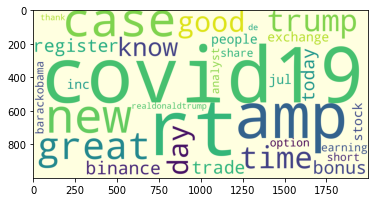

In [24]:
plt.imshow(wordcloud)

In [25]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.979179214002732

Coherence Score:  0.4361840153987855


In [26]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

/home/saanvi/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.163187  0.038718       1        1  35.194814
2     -0.212441 -0.004424       2        1  30.361811
1      0.060676 -0.106101       3        1  18.631035
3     -0.011423  0.071807       4        1  15.812340, topic_info=          Term          Freq         Total Category  logprob  loglift
352          $  32616.000000  32616.000000  Default  30.0000  30.0000
16     covid19   4594.000000   4594.000000  Default  29.0000  29.0000
925   register    937.000000    937.000000  Default  28.0000  28.0000
9106     bonus    872.000000    872.000000  Default  27.0000  27.0000
4196       inc   1310.000000   1310.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
650        big    144.297198    651.982729   Topic4  -6.0248   0.3362
9106     bonus    153.815378    872.673868   Topic4  -5.9609   0.1086
231        say    126.139942    536.773670   Topic4  -6.1593   0.3962
204       year    134.963754    802.251215   Topic4  -6.0917   0.0620
251        new    150.806295   1837.675466   Topic4  -5.9807  -0.6559

[349 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
18324      3  0.012823      #$^
18324      4  0.987405      #$^
352        1  0.010976        $
352        2  0.784442        $
352        3  0.076004        $
...      ...       ...      ...
13964      1  0.013413    zacks
13964      2  0.929976    zacks
13964      3  0.053652    zacks
13964      4  0.004471    zacks
13832      3  0.953335  ûïwhen

[855 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

Thank you